In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from sympy import fibonacci,prime,divisors,factorint
from z3 import *
from scipy.ndimage import measurements
from IPython.display import Markdown, display,Image,HTML

Show Solution The 11-by-11 grid above has been divided into various regions. Shade some of the cells black, then place digits (0-9) into the remaining cells. Shading must be “sparse”: that is, no two shaded cells may share an edge. Every cell within a region must contain the same digit, and orthogonally adjacent cells in different regions must have different digits. (Note that shading cells may break up regions or change which pairs of regions are adjacent. See the example, below.) Each row has been supplied with a clue. Every number formed by concatenating consecutive groups of unshaded cells within a row must satisfy the clue given for the row. (As in the example.)  Numbers must be at least two digits long and may not begin with a 0.

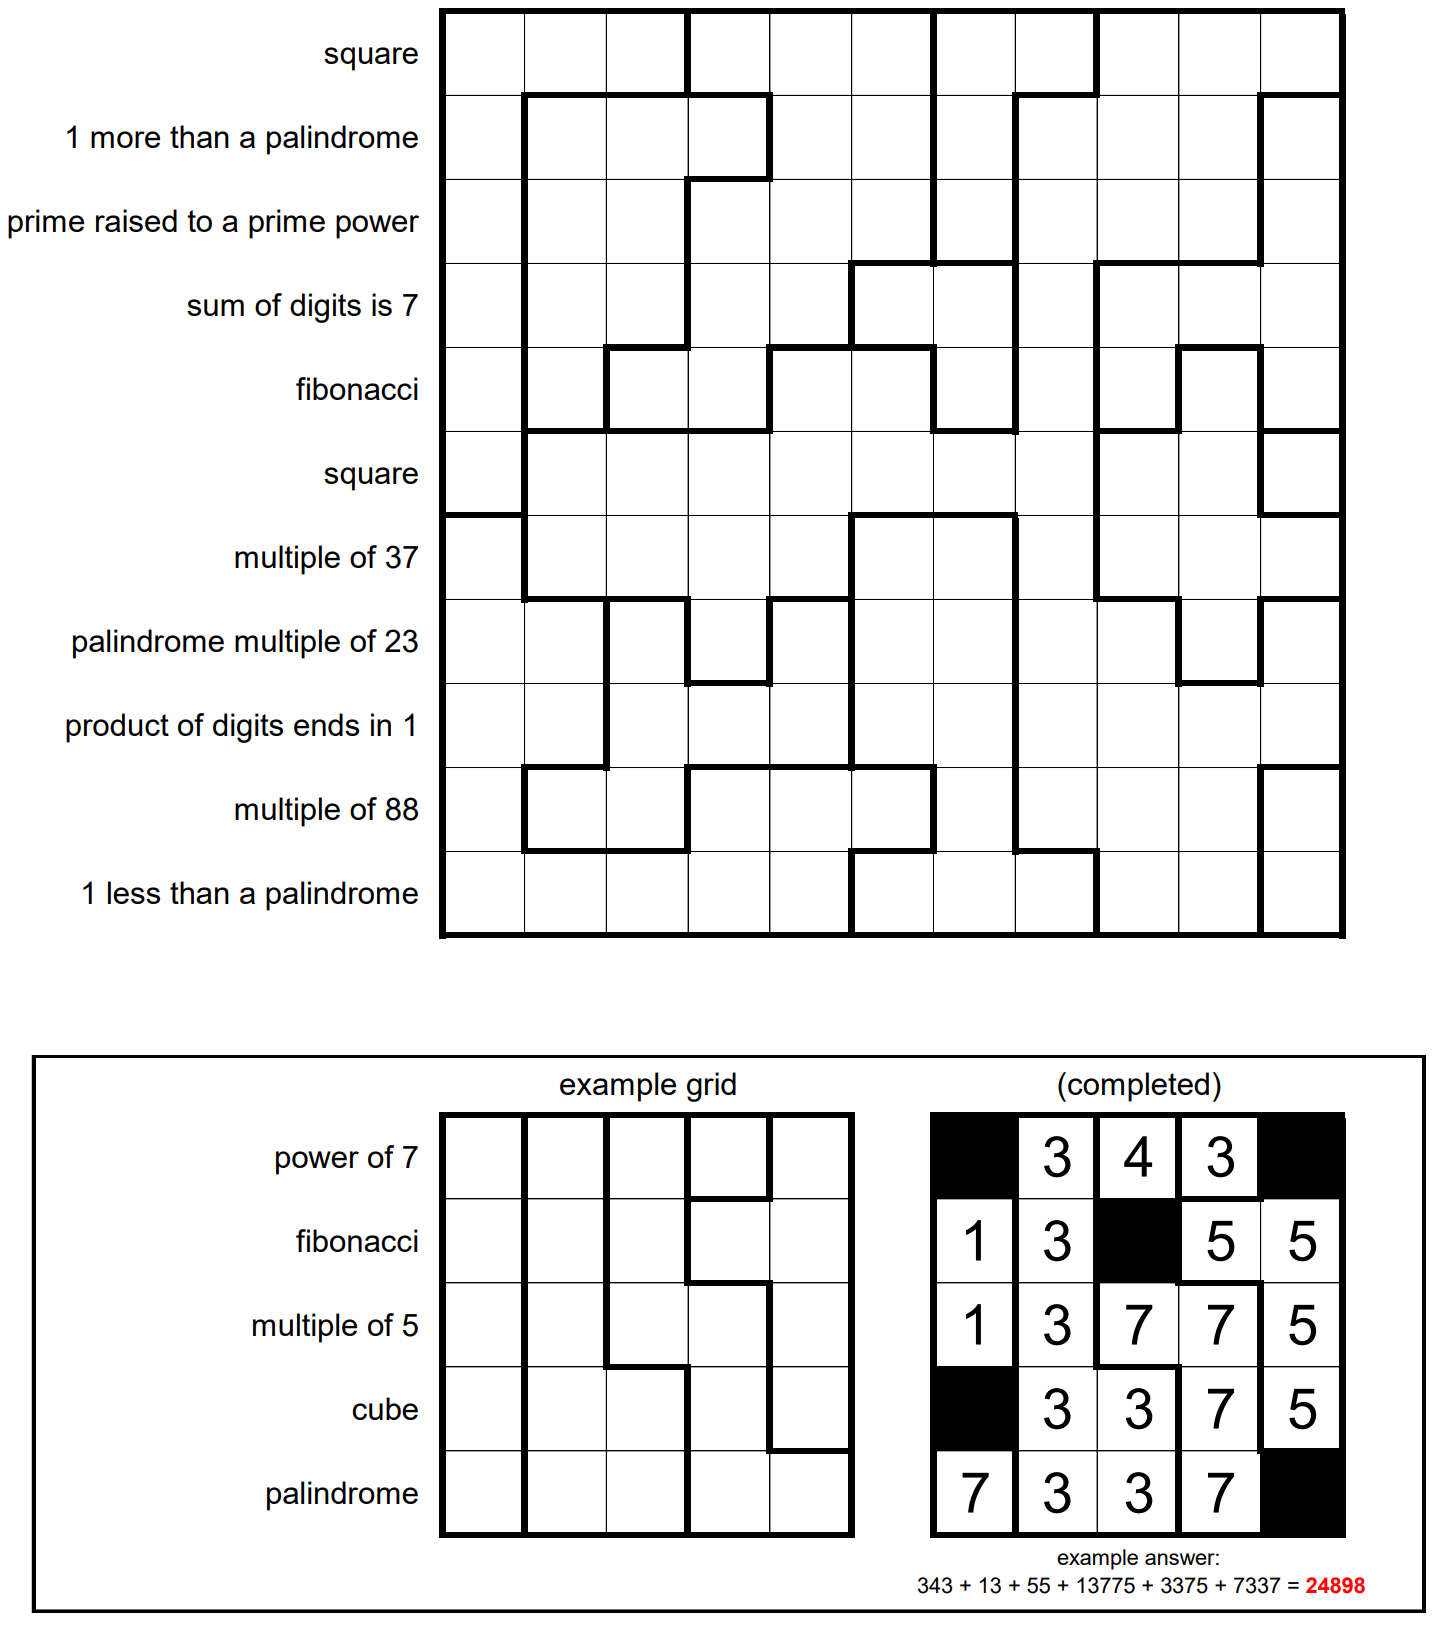

In [2]:
url='https://www.janestreet.com/puzzles/number-cross-4-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(x)])
display(Markdown(" ".join(x[15:23])))
display(Image('https://www.janestreet.com/puzzles/number-cross-4.PNG',width=400))

In [3]:
def sol_print(solved,matrix,blanks,labels):
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    x = np.array((matrix).astype('int').astype('str'))
    x[blanks==0] =""
    ax =sns.heatmap(solved,annot=x,cbar=False,cmap="tab20",fmt="",linewidths=2,linecolor='k',annot_kws={"fontsize":14,"color":"k"},alpha=.6,
    yticklabels=labels)
    ax.tick_params(left=False, bottom=False,labelleft=True, labelright=False,labeltop=False,labelbottom=False)
    plt.yticks(rotation=0,fontsize =10)

    plt.show()


In [4]:
def neigh(x,y,N):
    return [(i+x,j+y) for i,j in [(-1,0),(0,-1),(1,0),(0,1)] if i+x >=0 and i+x <N and j+y >=0 and j+y <N]

def blocks_as_number(split,line):
    block = 0
    inblock =0
    for n,p in enumerate(split):         
        if p ==1:
            if inblock == 0:
                block += line[n]
                inblock = 1
            else:
                block = block*10+line[n]
        else:
            if inblock == 1:
                yield block
                block = 0
                inblock = 0                    
    if inblock == 1:
        yield block
        
def solve_as_number(split,line):
    block = 0
    inblock =0
    for n,p in enumerate(split):         
        if p ==1:
            if inblock == 0:
                block += line[n]
                inblock = 1
            else:
                block = int(block*10+line[n])
        else:
            if inblock == 1:
                yield block
                block = 0
                inblock = 0                    
    if inblock == 1:
        yield block       
        
        
def block_as_sum_digits(split,line):
    block = 0
    inblock =0
    for n,p in enumerate(split):         
        if p ==1:
            if inblock == 0:
                block += line[n]
                inblock = 1
            else:
                block += line[n]        
        else:
            if inblock == 1:
                yield block
                block = 0
                inblock = 0                    
    if inblock == 1:
        yield block
        
def block_as_prod_digits(split,line):
    block = 1
    inblock =0
    for n,p in enumerate(split):         
        if p ==1:
            if inblock == 0:
                block *= line[n]
                inblock = 1
            else:
                block *= line[n]        
        else:
            if inblock == 1:
                yield block
                block = 1
                inblock = 0                    
    if inblock == 1:
        yield block        

        
def blocks_as_block(split,line):
    block = []
    inblock =0
    for n,p in enumerate(split):         
        if p ==1:
            block += [line[n]]
            inblock = 1
        else:
            if inblock == 1:
                yield block
                block = []
                inblock = 0                    
    if inblock == 1:
        yield block

def valid_shapes(length):
    poss = [[0],[1,1]]
    while len(poss) > 0:
        test = poss.pop()
        if len(test) == length:
            yield(test)
        elif len(test) > length:
            pass
        elif test[-1] == 0:
            poss += [test+[1,1]]
        else:
            poss += [test + [1]]
            poss += [test + [0]]          

In [5]:
def constraint_pow(line,ns,split,p):
    nums =[i for i in blocks_as_number(split,ns)]
    return Implies(And([line[i] == int(e) for i,e in enumerate(split)]),And([Or([n == i for i in [p**x for x in range(2,37)]]) for n in nums]))

def constraint_sq(line,ns,split,p):
    nums =[i for i in blocks_as_number(split,ns)]
    return Implies(And([line[i] == int(e) for i,e in enumerate(split)]),And([ToInt(n**0.5)==n**0.5 for n in nums]))

def constraint_cube(line,ns,split,p):
    nums =[i for i in blocks_as_number(split,ns)]
    return Implies(And([line[i] == int(e) for i,e in enumerate(split)]),And([Or([n == i for i in [x*x*x for x in range(1,100)]]) for n in nums]))

def constraint_fib(line,ns,split,p):
    nums =[i for i in blocks_as_number(split,ns)]
    return Implies(And([line[i] == int(e) for i,e in enumerate(split)]),And([Or([n == int(fibonacci(i)) for i in range(1,55)]) for n in nums]))

def constraint_mult(line,ns,split,p):
    nums =[i for i in blocks_as_number(split,ns)]
    return Implies(And([line[i] == int(e) for i,e in enumerate(split)]),And([n % p ==0 for n in nums]))

def constraint_digits(line,ns,split,p):
    nums =[i for i in block_as_sum_digits(split,ns)]
    return Implies(And([line[i] == int(e) for i,e in enumerate(split)]),And([n == p for n in nums]))

def constraint_prod(line,ns,split,p):
    nums =[i for i in block_as_prod_digits(split,ns)]
    return Implies(And([line[i] == int(e) for i,e in enumerate(split)]),And([n % 10 == p for n in nums]))

def pal_const(n,p):
    consts = [n[0]==n[-1]-p]
    for i in range(1,len(n)//2):
        consts += [n[i] == n[-1-i]]
    return consts

def constraint_pal(line,ns,split,p):
    nums =[i for i in blocks_as_block(split,ns)]
    return Implies(And([line[i] == int(e) for i,e in enumerate(split)]),And([And(pal_const(n,p))  for n in nums]))



In [6]:
def solve(test_grid,constraints):
    start = time.time()
    #set up the solver and variables.

    N = test_grid.shape[1]

    s = Tactic("default").solver()

    # B = Blanks 0 = block
    B = np.array(IntVector("b",N**2),dtype=object).reshape((N,N))
    s += [And(e>=0,e<=1) for (i,j),e in np.ndenumerate(B)]

    # N = nums    
    X= np.array(IntVector("x",N**2),dtype=object).reshape((N,N))
    s += [And(e>=0,e<=9) for (i,j),e in np.ndenumerate(X)]

    #neighbours
    s+= [And([Implies(And(int(test_grid[i,j]) != int(test_grid[x,y]),B[i,j]==1), X[i,j]!=e) for i,j in neigh(x,y,N)]) for (x,y),e in np.ndenumerate(X)]
    s+= [And([Implies(And(int(test_grid[i,j]) == int(test_grid[x,y]),B[x,y]==1), Or(X[i,j]==e,B[i,j]==0)) for i,j in neigh(x,y,N)]) for (x,y),e in np.ndenumerate(X)]
    s+= [And([Implies(B[x,y] == 0, B[i,j]==1) for i,j in neigh(x,y,N)]) for (x,y),e in np.ndenumerate(B)]

    # row constraints
    for i in range (N):
        s+= [Implies(B[i,j]==0,And(B[i,j+1] == 1,B[i,j+2] == 1)) for j in range(N-2)]
        s+= B[i,1] != 0
        s+= B[i,-2] != 0
        s+= [Implies(B[i,j] ==0 ,X[i,j+1] !=0) for j in range(N-1)]
        s+= X[i,0] != 0

    # #constraints
    for i,(constraint,param) in enumerate(constraints):
        print(i,constraint,param)
        if constraint == 'pow':
            for shape in valid_shapes(N):
                    s +=constraint_pow(B[i,:],X[i,:],shape,param)

        if constraint == 'fib':
            for shape in valid_shapes(N):
                    s +=constraint_fib(B[i,:],X[i,:],shape,param)

        if constraint == 'mult':
            for shape in valid_shapes(N):            
                    s +=constraint_mult(B[i,:],X[i,:],shape,param)

        if constraint == 'pal':
            for shape in valid_shapes(N):
                    s += constraint_pal(B[i,:],X[i,:],shape,param)

        if constraint == 'digits':
            for shape in valid_shapes(N):
                    s += constraint_digits(B[i,:],X[i,:],shape,param)   

        if constraint == 'prod':
            for shape in valid_shapes(N):
                    s += constraint_prod(B[i,:],X[i,:],shape,param)   

        if constraint == 'mult_pal':
            for shape in valid_shapes(N):
                    s += constraint_pal(B[i,:],X[i,:],shape,0)
                    s += constraint_mult(B[i,:],X[i,:],shape,param)

        if constraint == 'sq':
            for shape in valid_shapes(N):
                    s += constraint_sq(B[i,:],X[i,:],shape,0)

        if constraint == 'cube':
            for shape in valid_shapes(N):
                    s += constraint_cube(B[i,:],X[i,:],shape,0)

    if N==11:
        s += And([X[0,c] == v for c,v in enumerate([1,1,1,2,2,2,3,3,4,4,4])])
        s += And([B[0,c] == v for c,v in enumerate([1,1,1,1,1,1,1,1,1,1,1])])  

        s += And([X[2,c] == v for c,v in enumerate([1,3,3,1,0,7,3,4,4,4,9])])
        s += And([B[2,c] == v for c,v in enumerate([1,1,1,1,0,1,1,1,1,1,1])])   

        s += And([X[5,c] == v for c,v in enumerate([1,4,4,4,0,4,4,4,8,8,9])])
        s += And([B[5,c] == v for c,v in enumerate([1,1,1,1,0,1,1,1,1,1,1])])  

        # s += And([X[8,c] == v for c,v in enumerate([7,7,1,1,1,7,7,9,9,9,9])])
        # s += And([B[8,c] == v for c,v in enumerate([1,1,1,1,1,1,1,1,1,1,1])])  

    print("setup done in {:.2f} seconds".format(time.time()-start))       
    if s.check() == sat:
        m = s.model()
        evalu = np.vectorize(lambda x:m.evaluate(x).as_long())
        result_b =  np.array(evalu(B),dtype=int)
        result_x =  np.array(evalu(X),dtype=int)
        sol_print(test_grid,result_x*result_b,result_b,labels)
        print("Took {:.4f} seconds".format(time.time()- start))
        soln = result_x*result_b
        print("solution is {:,.0f}".format(sum([sum([i for i in solve_as_number(result_b[n,:],result_x[n,:])]) for n in range(N)])))
        print([[i for i in solve_as_number(result_b[n,:],result_x[n,:])] for n in range(N)])
        s += Or([int(result_b[i,j]) != e for (i,j),e in np.ndenumerate(B)]+[int(result_x[i,j]) != e for (i,j),e in np.ndenumerate(X)])
    else:
        print('fail')

0 pow 7
1 fib 0
2 mult 5
3 cube 0
4 pal 0
setup done in 0.19 seconds


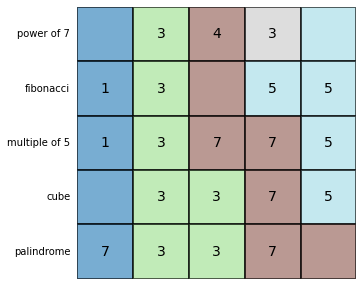

Took 0.3927 seconds
solution is 24,898
[[343], [13, 55], [13775], [3375], [7337]]


In [7]:
test_grid=np.array([[0, 1, 2, 3, 4],
                     [0, 1, 2, 4, 4],
                     [0, 1, 2, 2, 4],
                     [0, 1, 1, 2, 4],
                     [0, 1, 1, 2, 2]])

labels =['power of 7','fibonacci','multiple of 5','cube','palindrome']

constraints = [('pow',7),('fib',0),('mult',5),('cube',0),('pal',0)]

solve(test_grid,constraints)

0 sq 2
1 pal 1
2 prime 0
3 digits 7
4 fib 0
5 sq 2
6 mult 37
7 mult_pal 23
8 prod 1
9 mult 88
10 pal -1
setup done in 1.63 seconds


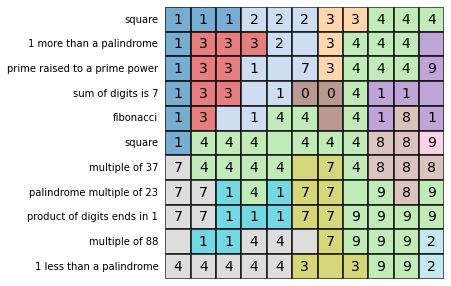

Took 32.1885 seconds
solution is 88,243,711,283
[[11122233444], [13332, 3444], [1331, 734449], [133, 100411], [13, 144, 4181], [1444, 444889], [74444, 74888], [7714177, 989], [77111779999], [1144, 79992], [444443, 3992]]


In [8]:
test_grid=      np.array([[0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 3],
                           [0, 4, 4, 4, 1, 1, 2, 3, 3, 3, 5],
                           [0, 4, 4, 1, 1, 1, 2, 3, 3, 3, 5],
                           [0, 4, 4, 1, 1, 6, 6, 3, 5, 5, 5],
                           [0, 4, 1, 1, 3, 3, 6, 3, 5, 7, 5],
                           [0, 3, 3, 3, 3, 3, 3, 3, 7, 7, 8],
                           [9, 3, 3, 3, 3,10,10, 3, 7, 7, 7],
                           [9, 9,11, 3,11,10,10, 3, 3, 7, 3],
                           [9, 9,11,11,11,10,10, 3, 3, 3, 3],
                           [9,11,11, 9, 9, 9,10, 3, 3, 3,12],
                           [9, 9, 9, 9, 9,10,10,10, 3, 3,12]])

labels =['square','1 more than a palindrome','prime raised to a prime power','sum of digits is 7','fibonacci','square','multiple of 37','palindrome multiple of 23',
         'product of digits ends in 1','multiple of 88','1 less than a palindrome']
constraints = [('sq',2),('pal',1),('prime',0),('digits',7),('fib',0),('sq',2),('mult',37),('mult_pal',23),('prod',1),('mult',88),('pal',-1)]
solve(test_grid,constraints)

The completed grid is shown above, and the sum of the concatenated numbers is 88243711283 . Of special note is the top row, 11122233444, which is both a square and has non-decreasing digits . Congrats to this month’s solvers!

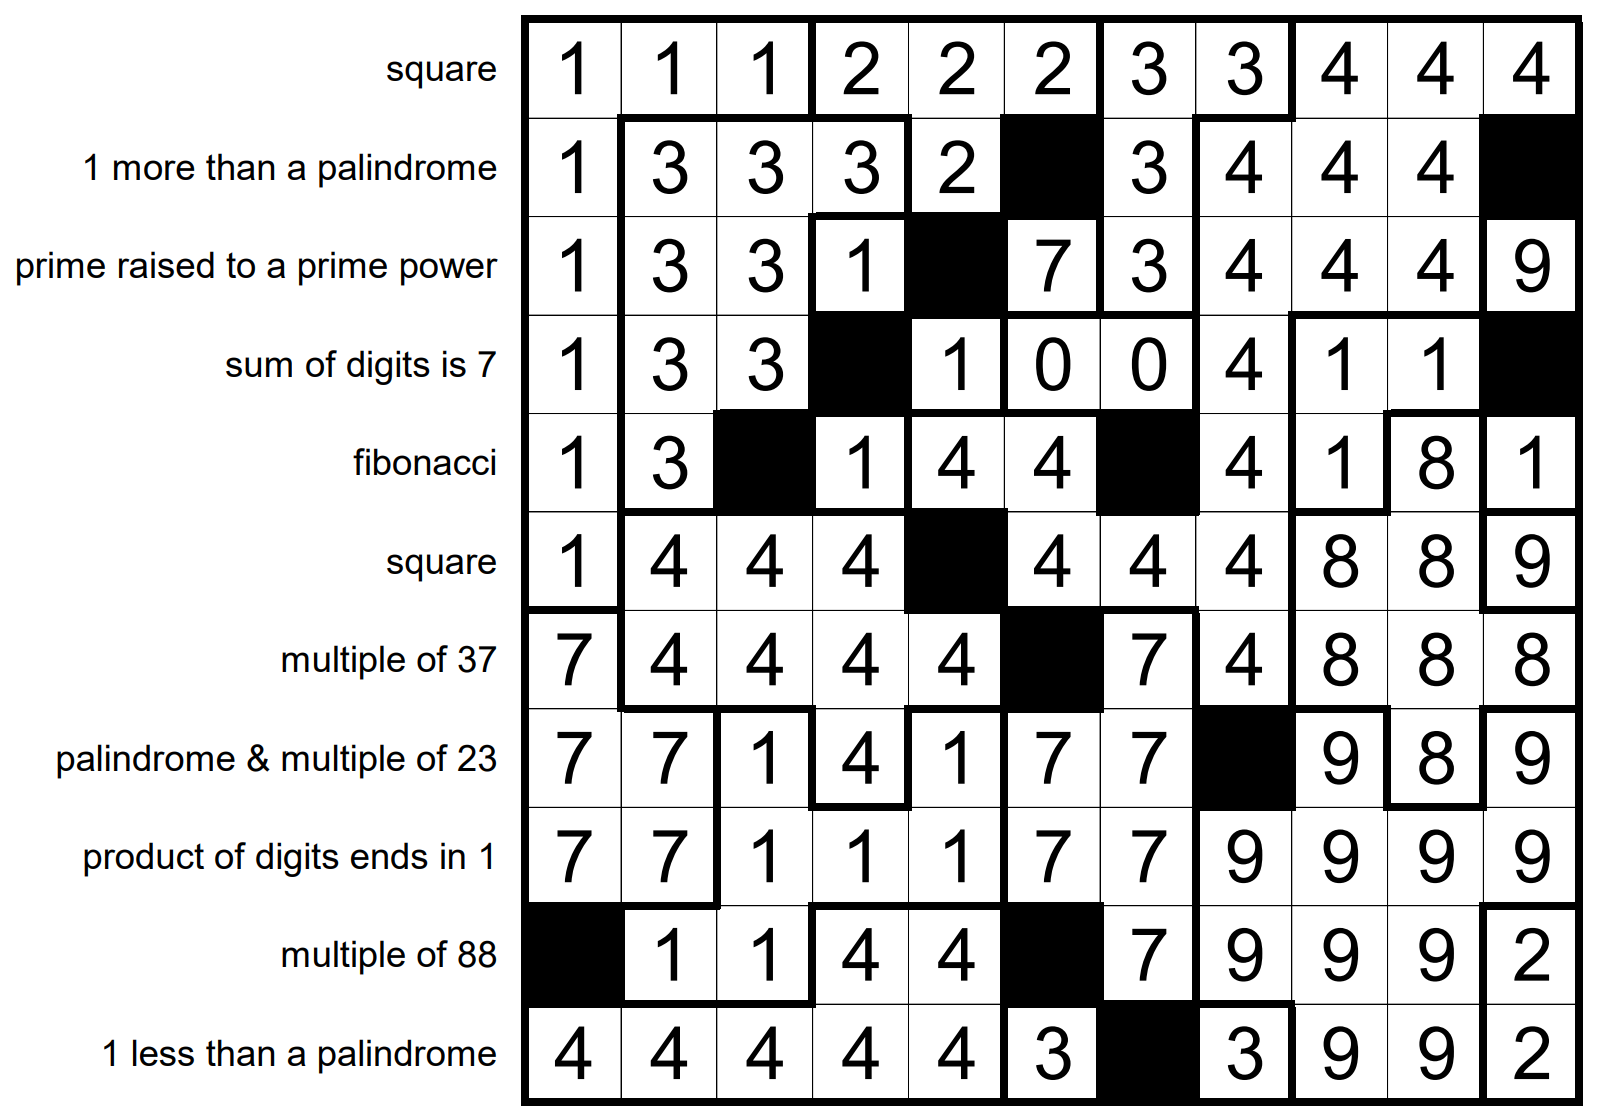

In [15]:
url='https://www.janestreet.com/puzzles/number-cross-4-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(x)])
display(Markdown(" ".join(x[16:23])))
display(Image('https://www.janestreet.com/puzzles/may-2024-solution.png',width=400))